In [1]:
import little_mallet_wrapper as lmw
import pandas as pd 
import ast 
from lmw import *
import textwrap
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk import word_tokenize
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

MALLET_PATH = "~/mallet/bin/mallet"
NAR_POS_PATH = "../../narrative_detection/narrative_posts_by_trained_classification.csv"
num_top = [10, 15, 20, 30]
output_directory_path = "../data/output/"

## Data Preprocessing

In [2]:
# Positive narrative dataset grouped by user ----
positive_df = pd.read_csv(NAR_POS_PATH)[['subreddit_id', 'author', 'selftext', 'title', 'id', 'created_utc']]
positive_df['selftext'] = positive_df['selftext'].replace(r'\n',' ', regex=True) 
positive_users = positive_df.groupby(["author", "subreddit_id"]).agg(list).reset_index()
positive_users = positive_users[positive_users['created_utc'].apply(lambda x: len(x) >= 2 and len(x) < 50)].reset_index(drop=True)

sum_post = []
for cluster in positive_users['selftext']: 
    for post in cluster: 
        sum_post.append(len(post.split()))
print("Number of users with at least 2 narrative positive posts:", len(positive_users))
print("Average number of words per post:", sum(sum_post)/len(sum_post))
print("Standard deviation of number of words per post:", np.std(sum_post))
print("Min/max number of words per post:", min(sum_post), max(sum_post))
positive_users.head(5)

Number of users with at least 2 narrative positive posts: 901
Average number of words per post: 220.56056338028168
Standard deviation of number of words per post: 141.52999182363467
Min/max number of words per post: 100 1913


,author,subreddit_id,selftext,title,id,created_utc
0,-CreamyPie-,t5_o3plh,[Hello! Im 11 and Im a boy self recovering fr...,"[Fear Food Friday!! So far its successful, Fea...","[gbj0rh, gagddu, g7xk05]","[1588343070, 1588190127, 1587836033]"
1,194569324,t5_s5o7i,[Just want to get this off my chest because I ...,"[Hardcore restricting, close to being discharg...","[g3255g, fvycov]","[1587130632, 1586178189]"
2,197326743251b,t5_2tmc8,[i can eat without rules im ok with not purg...,"[body image is the last thing to go, sensory o...","[pn4k5v, pjyyfb, oyf5pl]","[1631492734, 1631058338, 1628161076]"
3,40sareinteresting,t5_2tmc8,[I have been off and on bp for 20 years. It’s ...,"[Binging and gaining weight fast, How to truly...","[zyx8lq, ywoeic]","[1672395862, 1668588759]"
4,50gayrats,t5_rbmui,[Today my dad called go make sure I ate I said...,"[Eating disorder Health scare, My brother is s...","[10900qu, zy1gd0]","[1673426889, 1672307211]"


In [3]:
# Creating stopwords list ----
# Custom stopwords
with open("../data/input/custom_stop.txt", "r") as f:
    custom_stop = f.read().split()

# TF-IDF stopwords
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(positive_df['selftext'].tolist())
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
doc_frequency = (df_tfidf != 0).sum(axis=0)
doc_frequency = doc_frequency / len(positive_df)
df_tfidf = df_tfidf.loc[:, doc_frequency >= 0.5]
stop_tfidf = df_tfidf.columns.tolist()

# Final stoplist
stoplist = stopwords.words('english') + ["amp", "like"] + stop_tfidf

In [4]:
# Generating training data ----
training_data = [lmw.process_string(t) for post in positive_users['selftext'] for t in post]
training_data = [d for d in training_data if d.strip()]

# Generate groupings ----
groupings = []
counting = 0 
for item in positive_users['selftext']: 
    idx = []
    for post in item: 
        idx.append(counting)
        counting += 1
    groupings.append(idx)

## Training Topic Model
- Training data:
    + All posts in the database where the users post at least twice and fewer than 50 times.
    + Each document represent a post (post-level topic modeling).
    

In [5]:
# Training ----
'''
for num in num_top: 
    lmw_training(num, output_directory_path, training_data)
'''

'\nfor num in num_top: \n    lmw_training(num, output_directory_path, training_data)\n'

In [6]:
# Examining all topics (top_view.txt) ----
'''
with open(output_directory_path + "/top_view.txt", 'w') as f: 
    for num in num_top: 
        topic_keys = lmw.load_topic_keys(output_directory_path + "/mallet.topic_keys." + str(num))
        f.write("Topics for k=" + str(num) + "\n")
        for i, t in enumerate(topic_keys):
            line = str(i) + '\t' + ' '.join(t[:10]) + "\n"
            f.write(line)
        f.write('\n')
'''

'\nwith open(output_directory_path + "/top_view.txt", \'w\') as f: \n    for num in num_top: \n        topic_keys = lmw.load_topic_keys(output_directory_path + "/mallet.topic_keys." + str(num))\n        f.write("Topics for k=" + str(num) + "\n")\n        for i, t in enumerate(topic_keys):\n            line = str(i) + \'\t\' + \' \'.join(t[:10]) + "\n"\n            f.write(line)\n        f.write(\'\n\')\n'

## Analyzing Topics

In [7]:
# Reading in topic keys ----

num_topics = 20             # Change this to view different output files 

# Viewing topics ---- 
topic_keys = lmw.load_topic_keys(output_directory_path + "mallet.topic_keys." + str(num_topics))
topic_list = []
for i, t in enumerate(topic_keys):
    topic_list.append(' '.join(t[:10]))
topic_list

['purging binge purge binging stop bulimia b/p day cycle bad',
 'xNUMb hair would teeth dentist make mouth abs use email',
 'mom family fat dad sister said parents told comments always',
 'like feel even want know much get hate fucking never',
 'work get want time going need life back job hard',
 'like feel really also know lot think still idk maybe',
 'food mad buy money cookies store candy buying kitchen fucking',
 'know really get want eating think help tell disorder also',
 'eat eating food feel like meal even day hungry want',
 'people post group recovery made diet disordered certain looking posts',
 'weight gain lose gained eating back underweight bmi want NUM',
 'body look weight see clothes skinny fat looked face fit',
 'foods ate NUM eat food sugar chocolate cream ice cheese',
 'life eating self disorder things every people anxiety way mental',
 'never heart pain sick enough blood sleep night take water',
 'today didn felt got day going last back went time',
 'treatment inpati

In [8]:
# Get the most probable topic and topic distribution for each document ---- 
topic_distributions = lmw.load_topic_distributions(output_directory_path + "mallet.topic_distributions." + str(num_topics))

# Ungrouped
most_prob = [np.argmax(d) for d in topic_distributions]

# Grouped by user
most_prob_grouped, prob_grouped = [], []
for group in groupings:
    most_prob_grouped.append([most_prob[i] for i in group])
    prob_grouped.append([topic_distributions[i] for i in group])

positive_users['Topic Distribution'] = prob_grouped
positive_users['most_probable_topic'] = most_prob_grouped
# Order each element in list columns by created_utc ----
positive_users['selftext'] = positive_users['selftext'].apply(lambda x: [x for _,x in sorted(zip(positive_users['created_utc'], x))])
positive_users['title'] = positive_users['title'].apply(lambda x: [x for _,x in sorted(zip(positive_users['created_utc'], x))])
positive_users['id'] = positive_users['id'].apply(lambda x: [x for _,x in sorted(zip(positive_users['created_utc'], x))])
positive_users['Topic Distribution'] = positive_users['Topic Distribution'].apply(lambda x: [x for _,x in sorted(zip(positive_users['created_utc'], x))])
positive_users['most_probable_topic'] = positive_users['most_probable_topic'].apply(lambda x: [x for _,x in sorted(zip(positive_users['created_utc'], x))])
positive_users['created_utc'] = positive_users['created_utc'].apply(lambda x: sorted(x))
prob_grouped = positive_users['Topic Distribution'].tolist()
most_prob_grouped = positive_users['most_probable_topic'].tolist()
topic_distributions = [item for sublist in prob_grouped for item in sublist]

positive_users.head(2)
#exploded = positive_users.explode(['selftext', 'created_utc', 'title', 'Topic Distribution', 'most_probable_topic', 'id']).to_csv("../data/positive_topic_dist.csv")

,author,subreddit_id,selftext,title,id,created_utc,Topic Distribution,most_probable_topic
0,-CreamyPie-,t5_o3plh,[Alright so Its wednesday the day im typing th...,"[Fear Food Friday is almost here., Fear Food F...","[gagddu, gbj0rh, g7xk05]","[1587836033, 1588190127, 1588343070]","[[0.003704930553153588, 0.0008734280746749083,...","[15, 15, 12]"
1,194569324,t5_s5o7i,"[I feel horrible because I love him so much, b...","[My boyfriend triggers my eating disorder., Ha...","[fvycov, g3255g]","[1586178189, 1587130632]","[[0.03404512105871182, 0.0003010134634609527, ...","[8, 16]"


### Global Topic Transition

Antoniak 2019 time series analysis does not work on our dataset because we don't have fixed time interval

Number of users with exactly 2 posts: 541
Number of users with exactly 3 posts: 164
Number of users with exactly 4 posts: 80
Number of users with exactly 5 posts: 41
Number of users with exactly 6 posts: 19
Number of users with exactly 7 posts: 16
Number of users with exactly 8 posts: 12


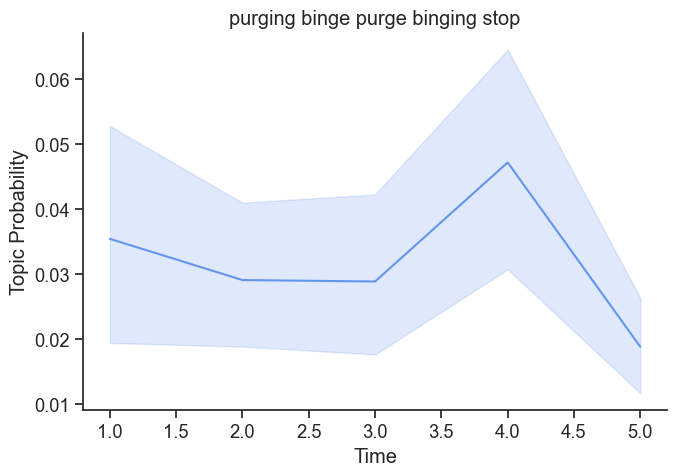

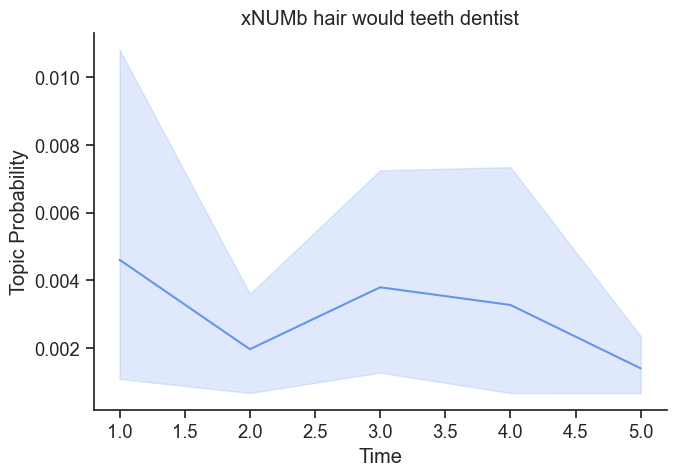

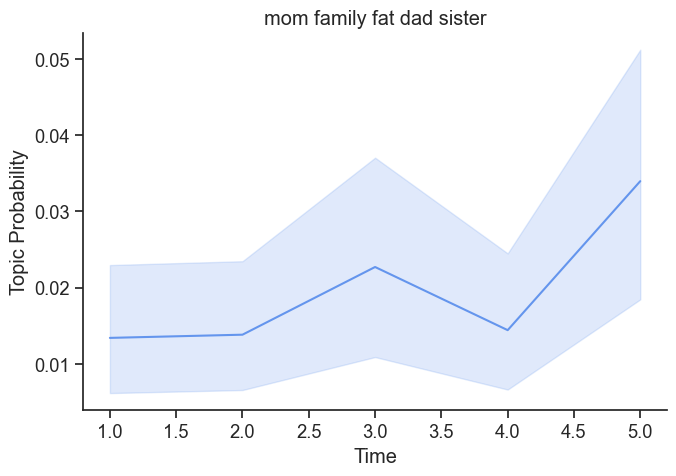

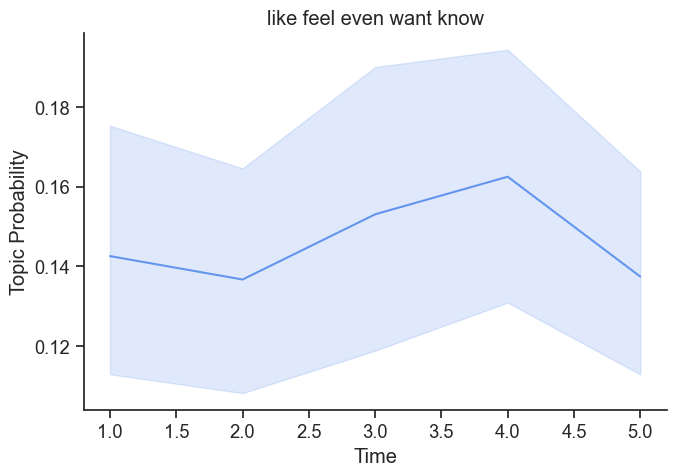

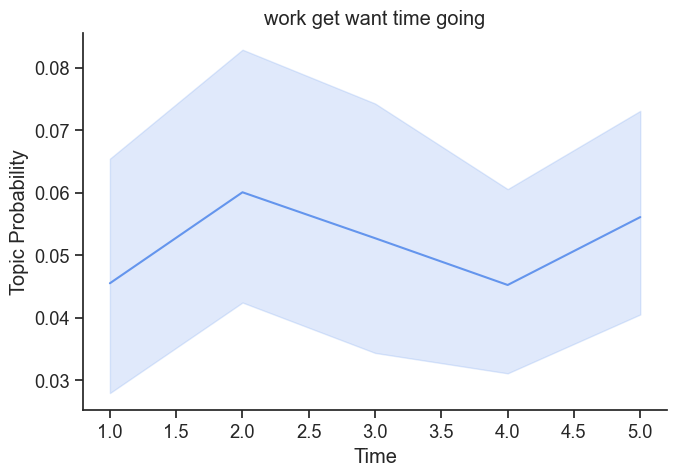

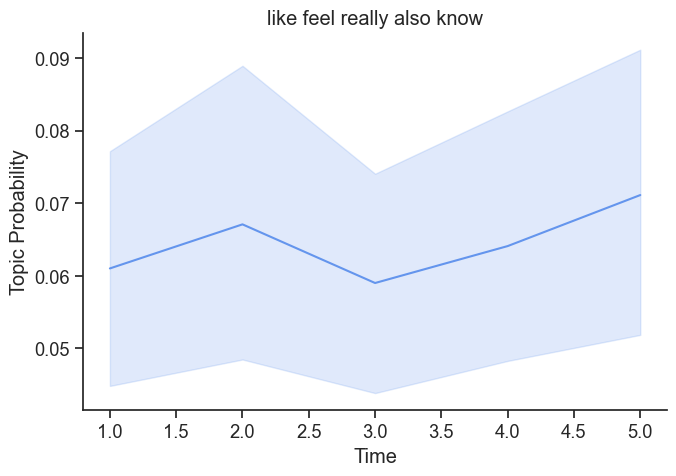

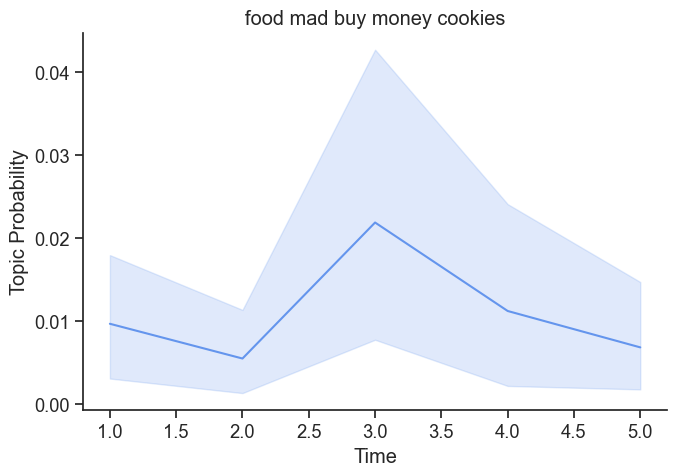

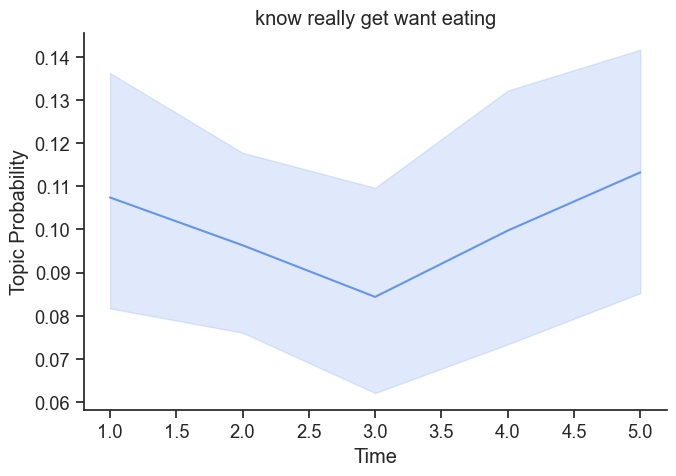

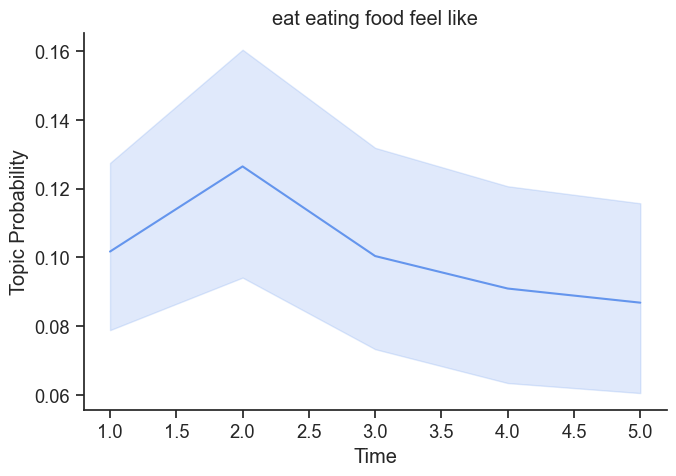

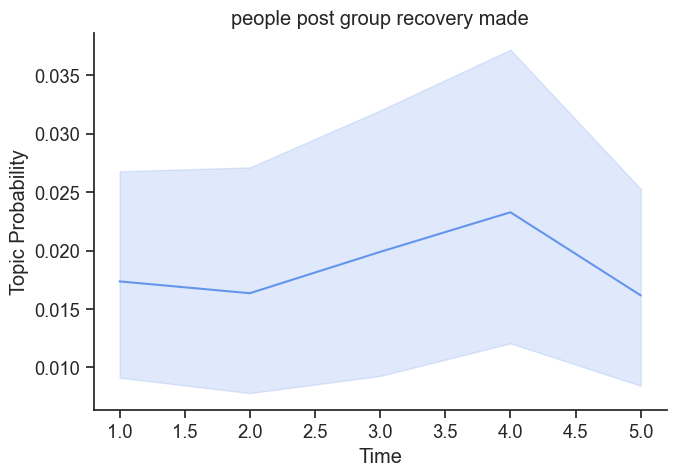

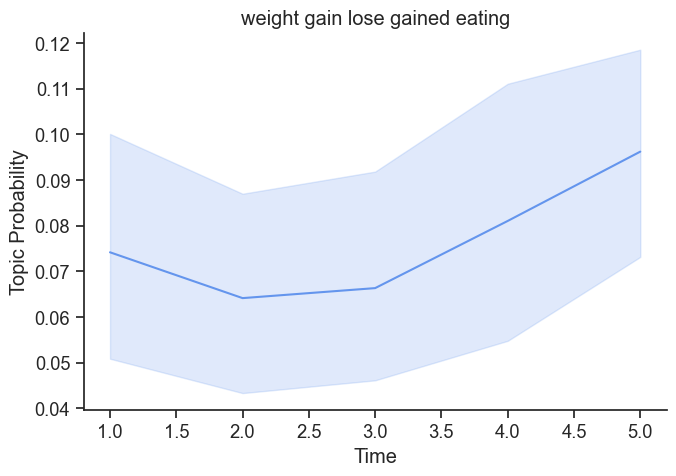

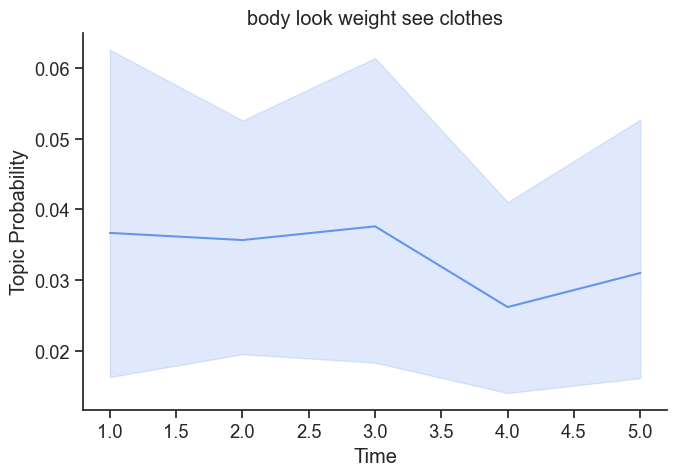

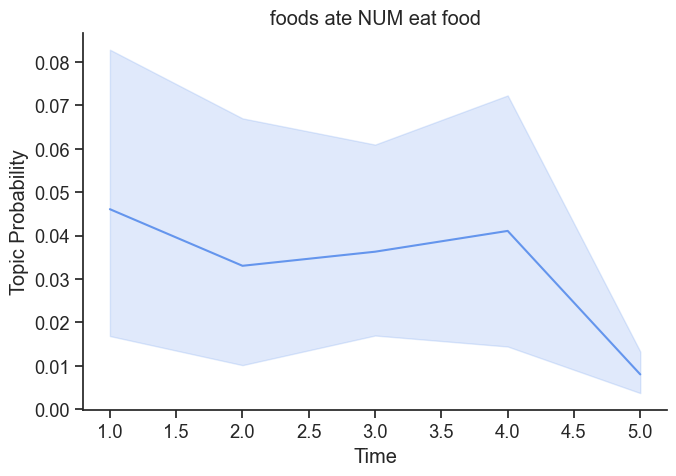

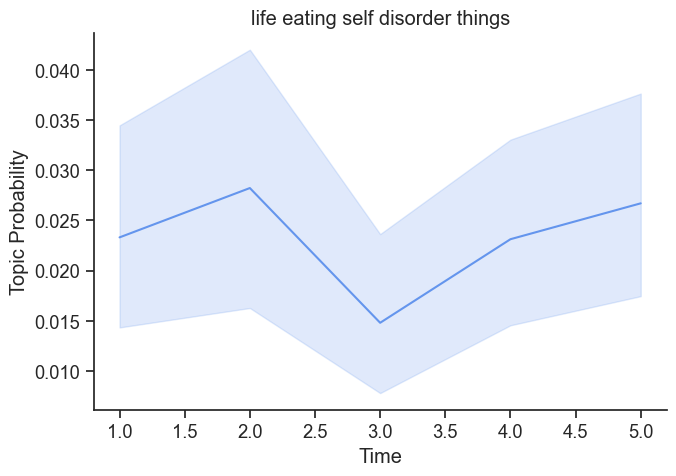

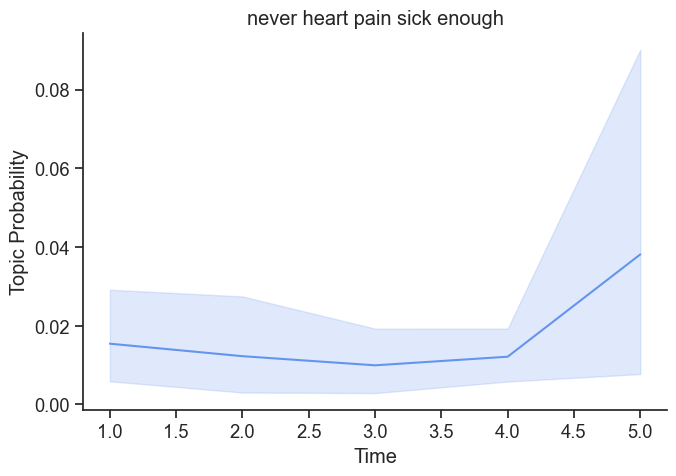

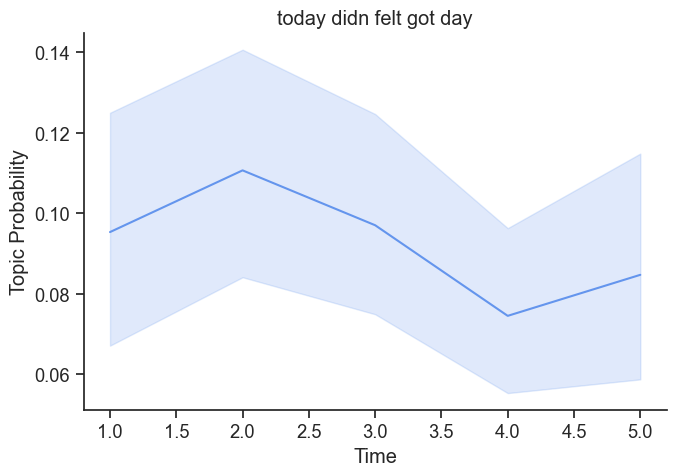

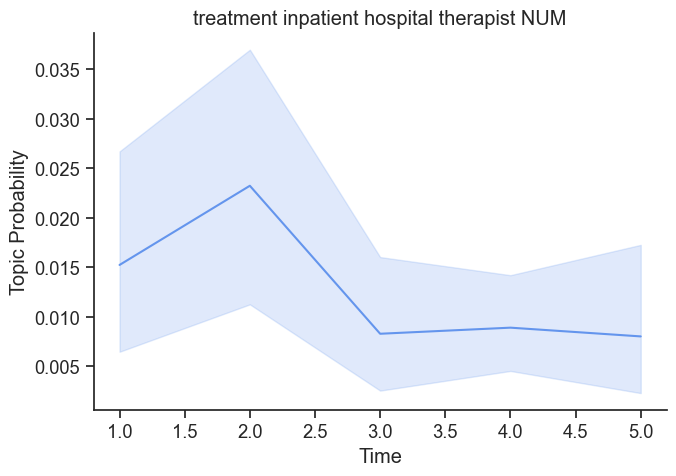

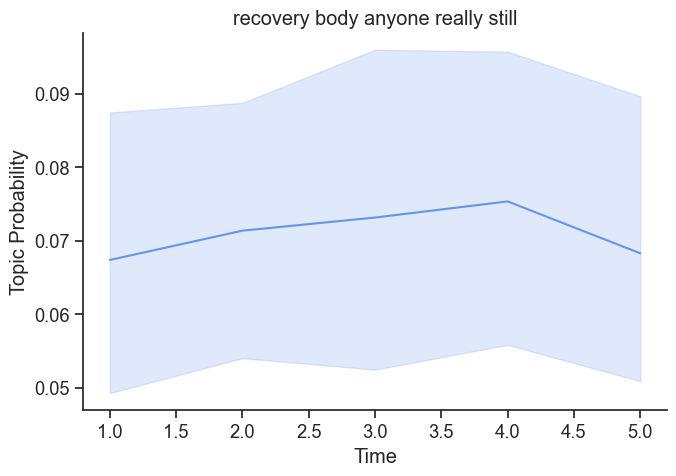

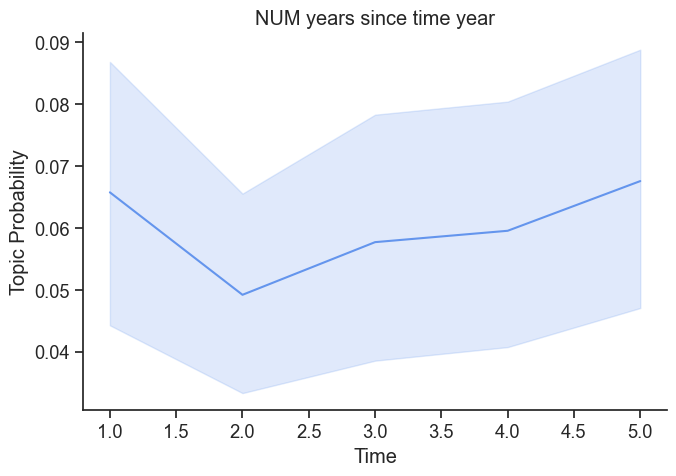

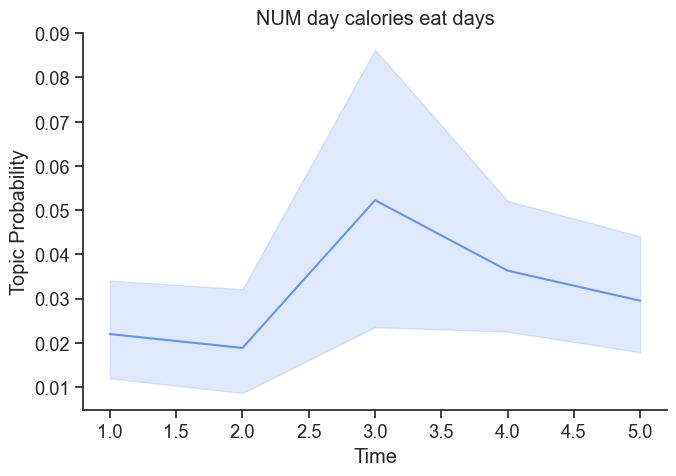

In [9]:
# Get users with exactly n posts ---- 
for i in [2,3,4,5,6,7,8]:
    print("Number of users with exactly", i, "posts:", len(positive_users[positive_users['created_utc'].apply(lambda x: len(x) == i)]))
user = positive_users[positive_users['created_utc'].apply(lambda x: len(x) == 5)].reset_index(drop=True)
topic_dist = [item for i in user['Topic Distribution'].tolist() for item in i]
times = [1, 2, 3, 4, 5] * len(user)

for _topic_index in range(0, len(topic_list)):
    data_dicts = []
    for j, _distribution in enumerate(topic_dist):        
        for _topic, _probability in enumerate(_distribution):
            if _topic == _topic_index:
                data_dicts.append({'Probability': _probability,
                                   'Time': times[j]})
    data_df = pd.DataFrame(data_dicts)

    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(7,5))
    sns.lineplot(data=data_df, 
                 x='Time', 
                 y='Probability', 
                 color='cornflowerblue') 
    plt.xlabel('Time')
    plt.ylabel('Topic Probability')
    plt.title(' '.join(topic_keys[_topic_index][:5]))
    plt.tight_layout()
    sns.despine()
    plt.show()

### Local Topic Transition
Following Akoury 2020, we examine common local topic transitions between entries written by the same user across time. We compute the transition probability from topic A to topic B by counting how many times A and B are the most probable topics for two consecutive entries, respectively, and normalizing by the total number of occurrences of topic A.

- Table in the paper: Topics with the highest relative importance, which illustrate the diversity of the dataset.

In [10]:
# Get the transition probability for each user ----
# transition_prob: List of dictionaries {topic A: {topic B: countBA}}
# topic_count: List of dictionaries {topic A: countA}
transition_count, topic_count = [], []
for user in most_prob_grouped:
    transition, topic = {}, {}
    for i in range(len(user)-1):
        if user[i] not in transition:
            transition[user[i]] = {user[i+1]: 1}
        else: 
            transition[user[i]][user[i+1]] = transition[user[i]].get(user[i+1], 0) + 1
        topic[user[i]] = topic.get(user[i], 0) + 1
    transition_count.append(transition)
    topic_count.append(topic)

# Normalize the transition probability ----
transition_prob_norm = []
for user in range(len(transition_count)): 
    transition_norm = {}
    for topicA in transition_count[user]: 
        for topicB in transition_count[user][topicA]: 
            transition_norm[topicA] = transition_norm.get(topicA, {})
            transition_norm[topicA][topicB] = transition_count[user][topicA][topicB] / topic_count[user][topicA]
    transition_prob_norm.append(transition_norm)

In [11]:
# Get the most probable transition for each user----
max_top = []
for user in transition_prob_norm:
    maxing = {}
    for topic in user:
        max_val = 0 
        max_topic = []
        for t in user[topic]:
            if user[topic][t] > max_val: 
                max_val = user[topic][t]
                max_topic = [t]
            elif user[topic][t] == max_val: 
                max_topic.append(t)
        maxing[topic] = max_topic
    max_top.append(maxing)


# Reformat max_top into a list of lists of tuples ----
all_users = []
for user in max_top: 
    user_list = []
    for topic in user: 
        for t in user[topic]: 
            user_list.append((topic, t))
    all_users.append(user_list)
all_users_expanded = [user[i] for user in all_users for i in range(len(user))]

In [12]:
# Get the most frequent transition across all users ----
max_top_freq = {}
for tup in all_users_expanded:
    # get the most frequent transition for each user 
    if tup[0] not in max_top_freq: 
        max_top_freq[tup[0]] = {tup[1]: 1}
    else:
        max_top_freq[tup[0]][tup[1]] = max_top_freq[tup[0]].get(tup[1], 0) + 1

# Get the value with the highest count for each topic ----
# Topic     Most Frequent Transition
topic_label = {}
with open("../data/analysis/topic_label_20.txt", 'r') as f:
    labs = f.readlines()
    labs = [t.strip() for t in labs]
    for topic in labs: 
        idx, label, keywords = topic.split("_")[0],  topic.split("_")[1],  topic.split("_")[2]
        if str(idx) not in topic_label: 
            topic_label[str(idx)] = [label, keywords]

print('Most common local topic transitions across users:')
for topic in max_top_freq: 
    print(topic_label[str(topic)][0], "---->", topic_label[str(max(max_top_freq[topic], key=max_top_freq[topic].get))][0])

Most common local topic transitions across users:
timeShort (moderate) ----> feeling (moderate)
eat(good) ----> eat(good)
feeling (moderate) ----> feeling (moderate)
timeLong (moderate) ----> feeling (moderate)
weight (good) ----> weight (good)
feeling (moderate) ----> feeling (moderate)
work (bad) ----> work (bad)
feeling (moderate) ----> feeling (moderate)
recovery (bad) ----> recovery (bad)
food (good) ----> food (good)
eating ----> recovery (bad)
appearance (good) ----> feeling (moderate)
groceryShopping (moderate) ----> timeShort (moderate)
life (bad) ----> feeling (moderate)
discomfort (moderate) ----> feeling (moderate)
bodyParts (good) ----> feeling (moderate)
formalTreatment (good) ----> work (bad)
family (good) ----> feeling (moderate)
calories (bad) ----> feeling (moderate)
community (moderate) ----> timeShort (moderate)


### Topic-sentiment analysis

In [ ]:
# Adding sentence polarity to each user (positive_users df) ----
submission_polarity = pd.read_csv("../../data_collection/submission_polarity.csv")
polarity_pos = []
for id in positive_users['id']: 
    subpolarity = []
    for subid in id: 
        subpolarity.append(submission_polarity[submission_polarity['id'] == subid]['sentence_polarity'].values[0])
    polarity_pos.append(subpolarity)
positive_users['post_polarity'] = polarity_pos

In [ ]:
# Average polarity per topic (polarity is assigned to the most probable topic in each document) ---- 
topic_polarity = {}
for i in range(len(positive_users)): 
    for j in range(len(most_prob_grouped[i])): 
        if str(most_prob_grouped[i][j]) not in topic_polarity: 
            topic_polarity[str(most_prob_grouped[i][j])] = [positive_users['post_polarity'][i][j]]
        else: 
            topic_polarity[str(most_prob_grouped[i][j])].append(positive_users['post_polarity'][i][j])

topic_polarity_avg = {}
for topic in topic_polarity:
    topic_polarity_avg[topic_label[topic][0]] = sum(topic_polarity[topic]) / len(topic_polarity[topic])

topic_polarity_avg

In [ ]:
# Get the polarity score associated with local topic transitions ----
# transition_polarity: List of dictionaries {topic A: {topic B: [polarityB - polarityA]}}
transition_polarity = []
for user in range(len(positive_users)):
    transition_user = {}
    for i in range(len(positive_users['most_probable_topic'][user])-1):
        transition_user[(positive_users['most_probable_topic'][user][i], positive_users['most_probable_topic'][user][i+1])] = transition_user.get((positive_users['most_probable_topic'][user][i], positive_users['most_probable_topic'][user][i+1]), [])
        transition_user[(positive_users['most_probable_topic'][user][i], positive_users['most_probable_topic'][user][i+1])].append(positive_users['post_polarity'][user][i+1] - positive_users['post_polarity'][user][i])
    transition_polarity.append(transition_user)

# Get average polarity score for each transition pair across all users ----
transition_polarity_avg = {}
for user in transition_polarity:
    for topic in user: 
        if topic not in transition_polarity_avg: 
            transition_polarity_avg[topic] = user[topic]
        else: 
            transition_polarity_avg[topic] += user[topic]

for topic in transition_polarity_avg: 
    transition_polarity_avg[topic] = sum(transition_polarity_avg[topic]) / len(transition_polarity_avg[topic])

transition_polarity_avg_sorted = dict(sorted(transition_polarity_avg.items(), key=lambda x: x[1], reverse=True))
print("Normalized polarity score for local topic transitions across users:")
for topic in transition_polarity_avg_sorted: 
    print(topic_label[str(topic[0])][0], "---->", topic_label[str(topic[1])][0], ":", transition_polarity_avg[topic])

### Topic-factor analysis

In [ ]:
# Match ids between positive_users and helpful/harmful df ----
# Get highest probable topic for each post ----
harmful = pd.read_csv("../data/input/harmful.csv")
helpful = pd.read_csv("../data/input/helpful.csv")

# Apply topic modeling to helpful and harmful posts ----
# Generating training data ----
harm_data = [lmw.process_string(post) for post in harmful['selftext']]
harm_data = [d for d in harm_data if d.strip()]
for num in [10, 20, 30, 50]: 
    lmw_training(num, "../data/output/harmful/", harm_data)
with open("../data/output/harmful/top_view.txt", 'w') as f: 
    for num in [10, 20, 30, 50]: 
        topic_keys = lmw.load_topic_keys("../data/output/harmful/mallet.topic_keys." + str(num))
        f.write("Topics for k=" + str(num) + "\n")
        for i, t in enumerate(topic_keys):
            line = str(i) + '\t' + ' '.join(t[:10]) + "\n"
            f.write(line)
        f.write('\n')

In [ ]:
# Getting the topic distribution for each post ----
harm_dist = lmw.load_topic_distributions("../data/output/harmful/mallet.topic_distributions.10")
topic_label_harm = {}
with open("../data/topic_lab_harm.txt", 'r') as f: 
    labs = f.readlines()
    labs = [t.strip() for t in labs]
    for topic in labs: 
        idx, label, keywords = topic.split("_")[0],  topic.split("_")[1],  topic.split("_")[2]
        if str(idx) not in topic_label_harm: 
            topic_label_harm[str(idx)] = [label, keywords]

# Get the most probable topic and topic distribution for each document ---- 
most_prob = [np.argmax(d) for d in harm_dist]
most_prob = [topic_label_harm[str(m)][0] for m in most_prob]

harmful['topic_dist'] = harm_dist
harmful['most_probable_topic'] = most_prob
harmful.to_csv("../data/harmful_topics.csv")

In [ ]:
# Apply topic modeling to helpful and harmful posts ----
# Generating training data ----
help_data = [lmw.process_string(post) for post in helpful['selftext']]
help_data = [d for d in help_data if d.strip()]
print(len(help_data))
for num in [5, 10]: 
    lmw_training(num, "../data/output/helpful/", help_data)
with open("../data/output/helpful/top_view.txt", 'w') as f: 
    for num in [5, 10]: 
        topic_keys = lmw.load_topic_keys("../data/output/helpful/mallet.topic_keys." + str(num))
        f.write("Topics for k=" + str(num) + "\n")
        for i, t in enumerate(topic_keys):
            line = str(i) + '\t' + ' '.join(t[:10]) + "\n"
            f.write(line)
        f.write('\n')

In [ ]:
# Getting the topic distribution for each post ----
help_dist = lmw.load_topic_distributions("../data/output/helpful/mallet.topic_distributions.10")
topic_label_help = {}
with open("../data/topic_lab_help.txt", 'r') as f: 
    labs = f.readlines()
    labs = [t.strip() for t in labs]
    for topic in labs: 
        idx, label, keywords = topic.split("_")[0],  topic.split("_")[1],  topic.split("_")[2]
        if str(idx) not in topic_label_help: 
            topic_label_help[str(idx)] = [label, keywords]

# Get the most probable topic and topic distribution for each document ---- 
most_prob = [np.argmax(d) for d in help_dist]
most_prob = [topic_label_help[str(m)][0] for m in most_prob]

helpful['topic_dist'] = help_dist
helpful['most_probable_topic'] = most_prob
helpful.to_csv("../data/helpful_topics.csv")